# Machine Learning Classification with Pycaret 

<div class="alert alert-block alert-info"> <b>THE TASK: </b> 
    Can we use UK historical weather data to find a classification algorithm that can predict whether a meteorological station is located in the northern, central, or southern third of the UK?
</div>

### The task and the metrics

This task will be a supervised multiclass classification problem, that is a classification predictive modelling problem where all outcome examples belong to one of the possible classes: North, Central or South.

The first question we must answer is: How do we know if our algorithm predictions are good enough? As this is a multiclass classification problem, with 3 possible classes, if we were doing a lucky guess and assuming the three classes are balanced, we´ll have 1/3 chances to get it right. So, we can consider 0.333 as our baseline accuracy and aim for a score greater than that.

### Getting the data

I will use the aggregated 10-year dataset with data from 37 UK meteorological weather stations that I created in the clustering exercise. The dataset is available in this repository as uk10data.csv.

In [1]:
#Import the first packages to start dealing with the data:
import pandas as pd
import numpy as np

In [2]:
# load data to start (change path yo your own computer path)
path= "Desktop/uk10data.csv"
uk10data=pd.read_csv(path)
uk10data.shape

(4428, 8)

### Assign labels to the stations

To divide the stations into 3 latitude bands, I calculate the min, max, 1/3 and 2/3 quantiles for all our latitude values. 
(if shoud we have a large amount of cities we could have use this values or code for defining the bin, with this code: bins = [uk10_latitude['latitude'].min(), uk10_latitude['latitude'].quantile(1/3), uk10_latitude['latitude'].quantile(2/3), uk10_latitude['latitude'].max()]

But as it is a short list and I am familiar with the locations of the stations, I preffer to pick the cutting boundaries manually by looking in the map and with the idea of keeping an aceptable balanced proportion of the three classes: 
1. upper limit in lerwick 60.13946 
2. north_central cut in ballypatrick 55.18062 
3. south-central cut in cwmystwyth 52.35817 
4. lower limit in camborne 50.21782

In [3]:
# lists with the latitudes and stations

list_latitude = [52.13914, 54.35234, 55.18062, 53.81341, 57.00612, 50.21782, 52.24501, 51.48783, 51.08865, 52.35817,
    56.45054, 54.76786, 50.76167, 55.311, 51.47872, 50.7789, 60.13946, 56.37745, 52.48323, 51.34597,
    57.593, 54.6699, 51.76073, 55.8455, 53.356, 51.91075, 52.79433, 53.38101, 50.89822, 58.21382,
    52.8331, 56.49999, 53.25238, 53.17509, 54.48073, 58.45406, 51.00586]
list_stations = ['aberporth', 'armagh', 'ballypatrick', 'bradford', 'braemar', 'camborne', 'cambridge', 'cardiff', 
                 'chivenor', 'cwmystwyth', 'dunstaffnage', 'durham', 'eastbourne', 'eskdalemuir', 'heathrow', 
                 'hurn', 'lerwick', 'leuchars', 'lowestoft', 'manston', 'nairn', 'newtonrigg', 'oxford', 'paisley', 
                 'ringway', 'rossonwye', 'shawbury', 'sheffield', 'southampton', 'stornoway', 'suttonbonington', 
                 'tiree', 'valley', 'waddington', 'whitby', 'wickairport', 'yeovilton']

# Create a dictionary with list_stations and list_latitude as values
data = {'station': list_stations, 'latitude': list_latitude}

# Create a DataFrame from the dictionary
stat_lat= pd.DataFrame(data)
stat_lat.sort_values(by='latitude', ascending=False)

,station,latitude
16,lerwick,60.13946
35,wickairport,58.45406
29,stornoway,58.21382
20,nairn,57.59300
4,braemar,57.00612
31,tiree,56.49999
10,dunstaffnage,56.45054
17,leuchars,56.37745
23,paisley,55.84550
13,eskdalemuir,55.31100


We merge both datafraes. Now we have in our previously created 10 years weather dataset the variable latitude 

In [4]:
# we merge both list and now have our original data with the latitude of the stations
uk10lat = pd.merge(uk10data,stat_lat,on='station', how='left')
uk10lat.head()

,yyyy,mm,tmax,tmin,af,rain,sun,station,latitude
0,2013.0,1,6.8,3.1,10.0,74.1,47.4,aberporth,52.13914
1,2013.0,2,6.7,2.0,4.0,60.4,90.5,aberporth,52.13914
2,2013.0,3,6.6,1.0,13.0,40.0,127.3,aberporth,52.13914
3,2013.0,4,10.3,4.3,5.0,33.4,184.2,aberporth,52.13914
4,2013.0,5,12.2,6.4,0.0,60.8,196.9,aberporth,52.13914


In [5]:
uk10lat['latitude'].min()

50.21782

In [6]:
uk10lat['latitude'].quantile(1/3)

52.24501

In [7]:
uk10lat['latitude'].quantile(2/3)

54.6699

In [8]:
uk10lat['latitude'].max()

60.13946

In [9]:
# Define the latitude bins and labels
bins = [50, 52.3, 55, 61]

# labels for each group
labels = ["South","Central", "North"]

# Add a new column with latitude groups
uk10lat['area'] = pd.cut(uk10lat['latitude'], bins=bins, labels=labels)

# Display the updated DataFrame
print(uk10lat)

        yyyy  mm  tmax  tmin    af   rain    sun    station  latitude   area
0     2013.0   1   6.8   3.1  10.0   74.1   47.4  aberporth  52.13914  South
1     2013.0   2   6.7   2.0   4.0   60.4   90.5  aberporth  52.13914  South
2     2013.0   3   6.6   1.0  13.0   40.0  127.3  aberporth  52.13914  South
3     2013.0   4  10.3   4.3   5.0   33.4  184.2  aberporth  52.13914  South
4     2013.0   5  12.2   6.4   0.0   60.8  196.9  aberporth  52.13914  South
...      ...  ..   ...   ...   ...    ...    ...        ...       ...    ...
4423  2022.0   8  25.7  12.8   0.0   15.4  225.0  yeovilton  51.00586  South
4424  2022.0   9  19.8   9.9   0.0   57.4  122.3  yeovilton  51.00586  South
4425  2022.0  10  17.9   9.8   1.0  111.2    NaN  yeovilton  51.00586  South
4426  2022.0  11  13.2   6.9   1.0  131.8   80.4  yeovilton  51.00586  South
4427  2022.0  12   7.8   0.4  13.0   81.4   54.1  yeovilton  51.00586  South

[4428 rows x 10 columns]


### Some Exploratory Data Analysis

Summary to see if there are any outliers, exploration for missing values and some basic visualizations. Important to see if the target classes are well balanced.

In [10]:
# data types and summary stats.
uk10lat.describe()

,yyyy,mm,tmax,tmin,af,rain,sun,latitude
count,4428.000000,4428.000000,4354.000000,4380.000000,4378.000000,4395.000000,2983.000000,4428.000000
mean,2016.002710,6.500000,13.716559,6.611005,2.773641,78.489488,122.452129,53.785164
std,6.019845,3.452442,5.040405,4.066171,4.429961,54.313858,64.817662,2.490520
min,1989.000000,1.000000,2.200000,-4.600000,0.000000,0.000000,7.900000,50.217820
25%,2014.000000,3.750000,9.400000,3.200000,0.000000,40.400000,68.000000,51.760730
50%,2017.000000,6.500000,13.300000,6.200000,0.000000,66.000000,116.000000,53.252380
75%,2020.000000,9.250000,17.800000,10.200000,4.000000,102.600000,168.750000,55.311000
max,2022.000000,12.000000,28.300000,16.400000,26.000000,568.800000,339.500000,60.139460


In [11]:
# count the nulls/missing data in each column
# not too bad - we might need to fill/delete these rows later
uk10lat.isnull().sum()

yyyy           0
mm             0
tmax          74
tmin          48
af            50
rain          33
sun         1445
station        0
latitude       0
area           0
dtype: int64

array([[<Axes: title={'center': 'yyyy'}>, <Axes: title={'center': 'mm'}>,
        <Axes: title={'center': 'tmax'}>],
       [<Axes: title={'center': 'tmin'}>, <Axes: title={'center': 'af'}>,
        <Axes: title={'center': 'rain'}>],
       [<Axes: title={'center': 'sun'}>,
        <Axes: title={'center': 'latitude'}>, <Axes: >]], dtype=object)

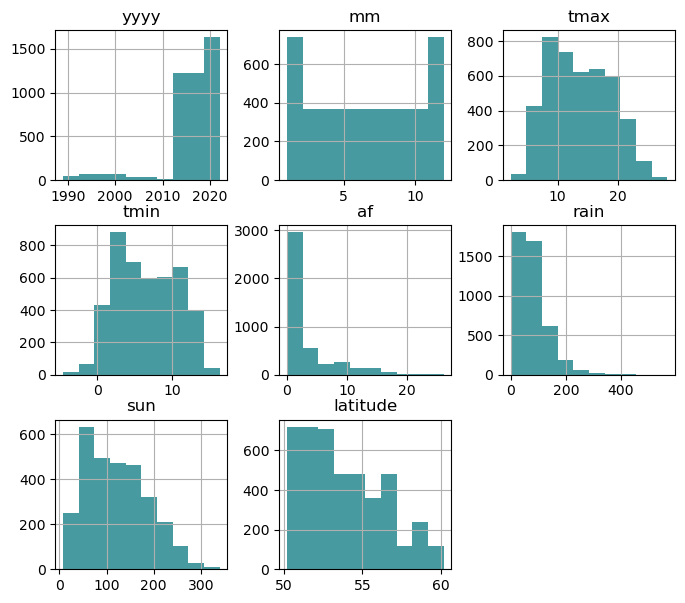

In [12]:
# Plot distributions...
uk10lat.hist(figsize = (8,7), color="#479a9f")

<Axes: >

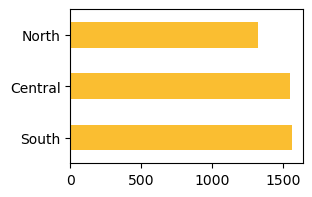

In [13]:
# We can see the three classes in the target variable  are well balanced
uk10lat
uk10lat['area'].value_counts().plot(kind='barh', color="#fabe31", figsize=(3,2))
                                   

### Select features for modeling

At this point we can discard variables we don´t need for the modeling. I eliminated "yyyy" as it doesn´t apport too much information and "latitude" as it is the variable we have used to create the target feature. I also eliminate the variable "sun" as it has more than 30% of missing values and anyway it is probable highly correlated with the variable "rain" . We can select the features by referring to the data frame using a list containing the features names we want:

In [14]:
# define the list
selected_features = ["mm","tmax","tmin","af","rain","area"]
# use only the selected features in the list
weather_df = uk10lat[selected_features]
weather_df

,mm,tmax,tmin,af,rain,area
0,1,6.8,3.1,10.0,74.1,South
1,2,6.7,2.0,4.0,60.4,South
2,3,6.6,1.0,13.0,40.0,South
3,4,10.3,4.3,5.0,33.4,South
4,5,12.2,6.4,0.0,60.8,South
...,...,...,...,...,...,...
4423,8,25.7,12.8,0.0,15.4,South
4424,9,19.8,9.9,0.0,57.4,South
4425,10,17.9,9.8,1.0,111.2,South
4426,11,13.2,6.9,1.0,131.8,South


### Experiment  with PyCaret

Although pyCaret will do the train_test_split, as we have enough data for it , we are going to hold a proportion of the data from the original dataset to be used for predictions in a final test to double check the algorithm is working in totally unseen data. After this split, we still have 3542 instances for the modellling. 

In [15]:
#split the data: one set for modeling and another set for the final test
modeling_data = weather_df.sample(frac=0.8, random_state=42).reset_index(drop=True)
unseen_data= weather_df.drop(modeling_data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(modeling_data.shape))
print('Unseen Data For Predictions: ' + str(unseen_data.shape))

Data for Modeling: (3542, 6)
Unseen Data For Predictions: (886, 6)


In [16]:
unseen_data.head()

,mm,tmax,tmin,af,rain,area
0,3,8.8,3.8,1.0,142.0,North
1,4,12.5,5.8,0.0,44.2,North
2,5,12.0,5.8,1.0,61.2,North
3,6,14.4,9.2,0.0,77.8,North
4,7,17.6,12.2,0.0,90.0,North


In [17]:
# Import pycaret libraries for classification tasks
from pycaret.classification import *

In [18]:
# init setup
s = setup(data=modeling_data, target="area", session_id=28, fold=5, categorical_features = ["mm"])

,Description,Value
0,Session id,28
1,Target,area
2,Target type,Multiclass
3,Target mapping,"Central: 0, North: 1, South: 2"
4,Original data shape,"(3542, 6)"
5,Transformed data shape,"(3542, 17)"
6,Transformed train set shape,"(2479, 17)"
7,Transformed test set shape,"(1063, 17)"
8,Numeric features,4
9,Categorical features,1


In [19]:
#compare which model is the best one for our data
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.5926,0.7833,0.5926,0.5934,0.5924,0.3874,0.3877,1.9480
gbc,Gradient Boosting Classifier,0.5805,0.7555,0.5805,0.5839,0.5811,0.3682,0.3688,1.9760
lightgbm,Light Gradient Boosting Machine,0.5764,0.7696,0.5764,0.5759,0.5752,0.3632,0.3638,2.3560
lr,Logistic Regression,0.5744,0.7529,0.5744,0.5669,0.5685,0.3609,0.3624,3.5400
lda,Linear Discriminant Analysis,0.5704,0.7520,0.5704,0.5668,0.5678,0.3542,0.3547,1.8520
et,Extra Trees Classifier,0.5704,0.7608,0.5704,0.5716,0.5705,0.3538,0.3542,1.8960
xgboost,Extreme Gradient Boosting,0.5668,0.7600,0.5668,0.5679,0.5665,0.3481,0.3486,1.8980
rf,Random Forest Classifier,0.5652,0.7566,0.5652,0.5658,0.5650,0.3462,0.3465,2.0040
ridge,Ridge Classifier,0.5587,0.0000,0.5587,0.5403,0.5278,0.3402,0.3539,1.9860
ada,Ada Boost Classifier,0.5252,0.7027,0.5252,0.5268,0.5250,0.2850,0.2856,2.0180


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [20]:
# Build a CatBoost Classifier for our data
cb = create_model("catboost")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5847,0.7867,0.5847,0.5898,0.5865,0.3754,0.3760
1,0.5706,0.7793,0.5706,0.5707,0.5706,0.3546,0.3546
2,0.6250,0.8025,0.6250,0.6247,0.6248,0.4360,0.4360
3,0.5786,0.7678,0.5786,0.5725,0.5743,0.3675,0.3684
4,0.6040,0.7804,0.6040,0.6090,0.6058,0.4032,0.4037
Mean,0.5926,0.7833,0.5926,0.5934,0.5924,0.3874,0.3877
Std,0.0196,0.0114,0.0196,0.0209,0.0204,0.0291,0.0290


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
# Tune the hyperparameters of the model we have just created
cb_tuned = tune_model(cb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6048,0.7835,0.6048,0.6073,0.6058,0.4057,0.4059
1,0.5948,0.7774,0.5948,0.5935,0.5940,0.3910,0.3911
2,0.6089,0.7966,0.6089,0.6088,0.6084,0.4110,0.4114
3,0.5746,0.7627,0.5746,0.5710,0.5722,0.3605,0.3609
4,0.5818,0.7611,0.5818,0.5862,0.5834,0.3700,0.3704
Mean,0.5930,0.7762,0.5930,0.5933,0.5928,0.3877,0.3879
Std,0.0131,0.0133,0.0131,0.0140,0.0136,0.0196,0.0196


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


<div class="alert alert-block alert-success"> <b>NOTE: </b> 
    Note: it could be worthy to experiment tuning the other classifiers shown in the compare_model() ranking table with similar metrics (gbc, lightgbm, lr) as they may outperform the top one in the ranking after the hyperparameters tuning. 
</div>

In [22]:
# predict on the pycaret test set
predict = predict_model(cb_tuned)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.5992,0.7825,0.5992,0.6027,0.6000,0.3957,0.3962


In [23]:
# final model will be trained with all data we entered in pycaret. 
# and it will have a higher accuracy 

final_model = finalize_model(cb_tuned)
final_predict = predict_model(final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7037,0.8663,0.7037,0.7036,0.7032,0.5538,0.5541


### Evaluation and Explainability of the classifier
the evaluate_model() function output a range of metrics:  

In [24]:
# you can click on any of them to see the metric plot
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

or call only the plot we want

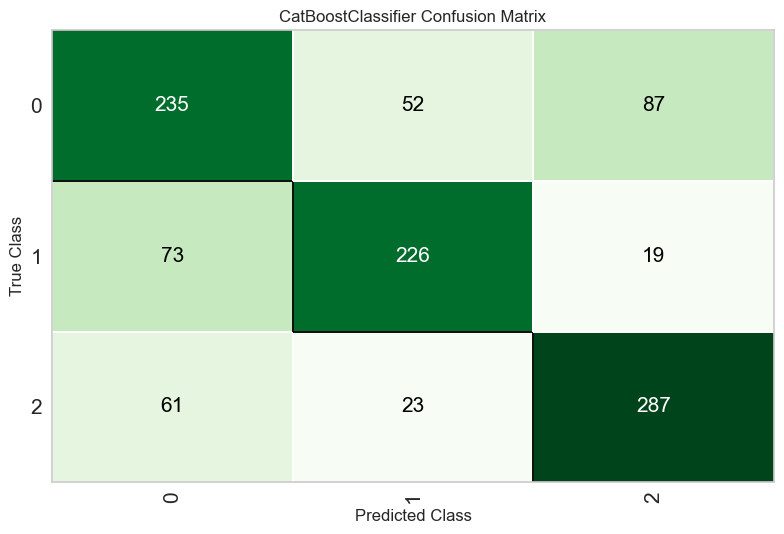

In [25]:
plot_model(final_model, plot = 'confusion_matrix')

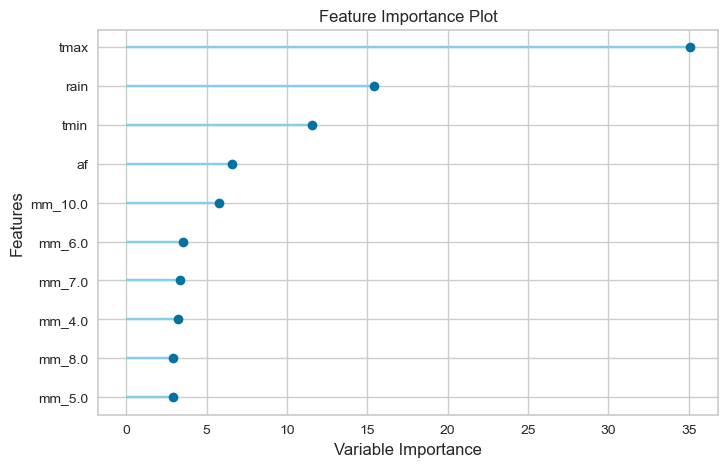

In [26]:
# plot feature importance
plot_model(final_model, plot = 'feature')

### Real predictions - final test
Now, using the same function predict_model() we can check how the model performs with the 20% data we separated in notebook cell nº 16, before using Pycaret, meaning this data hasn´t been seen by the algorithm at all.

In [27]:
real_predictions = predict_model(final_model, unseen_data)
real_predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.6941,0.8889,0.6941,0.7758,0.7107,0.5308,0.5559


,mm,tmax,tmin,af,rain,area,prediction_label,prediction_score
0,3,8.800000,3.8,1.0,142.000000,1,North,0.8294
1,4,12.500000,5.8,0.0,44.200001,1,South,0.5675
2,5,12.000000,5.8,1.0,61.200001,1,North,0.6708
3,6,14.400000,9.2,0.0,77.800003,1,North,0.8185
4,7,17.600000,12.2,0.0,90.000000,1,North,0.4978
...,...,...,...,...,...,...,...,...
881,8,25.700001,12.8,0.0,15.400000,2,South,0.6340
882,9,19.799999,9.9,0.0,57.400002,2,South,0.7534
883,10,17.900000,9.8,1.0,111.199997,2,South,0.6442
884,11,13.200000,6.9,1.0,131.800003,2,South,0.6122


As expected, accuracy in the unseen data is a bit lower, but very very close to the final_model accuracy. That also means that our model fits the training data well and it is also able to generalize and make predictions on new data. Now we can go back to our assumption on how a good our algorithm should be. We said 33% (you can also compare with the dummy classifier at the botton of the compare model() results). I think we can give thumbs up to this final model and save it for its use.

### Saving the algorithm

In [28]:
# save pipeline
save_model(final_model, 'my_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\Casa\AppData\Local\Temp\joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['tmax', 'tmin', 'af', 'rain'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               ke...
                                                               strategy='most_frequent',
                                                               verbose='deprecated'))),
                 ('onehot_encoding',
                  TransformerWrapper(exclud

### Loading the pipeline

In [29]:
# load pipeline when you need it 
loaded_best_pipeline = load_model('my_pipeline')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\Casa\AppData\Local\Temp\joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['tmax', 'tmin', 'af', 'rain'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              ke...
                                                              strategy='most_frequent',
                                                              verbose='deprecated'))),
                ('onehot_encoding',
                 TransformerWrapper(exclude=None, include=['mm'],
                                    transformer=OneHotEncoder(cols=['mm'],
                                                              drop_invariant=False,
                                                              handle_missing='return_nan',
                                                              handle_unknown='value',
                                                              return_df=True,
                                                              use_cat_names=True,
                                                              verbose=0))),
                ('actual_estimator',
                 <catboost.core.CatBoostClassifier object at 0x00000210800B6E00>)],
         verbose=False)